In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import sys, importlib
sys.path.append('/Users/work/Desktop/Research/Experimental Data/Fall-2024-Cl2/_shared_packages')
import process_cl2_logfile as process_cl2#This underline us unavoidable
pass
from IPython.display import display

use_nominal_cl2 = True

<h1> 9-27 Humidity Sweep </h1>

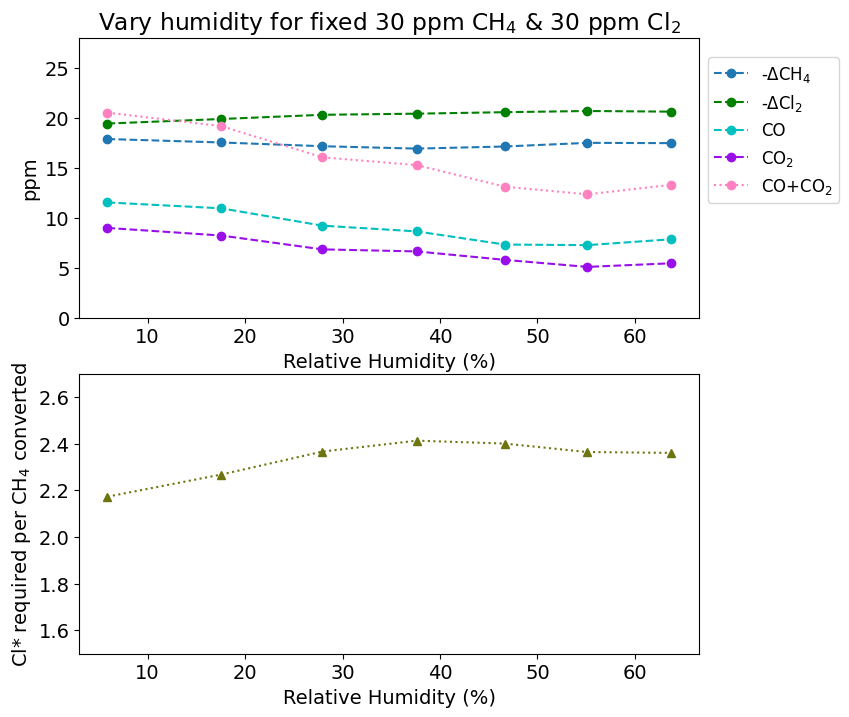

In [3]:
# Import stuff
bypass_data_929 = pd.read_csv("/Users/work/Desktop/Research/Experimental Data/Fall-2024-Cl2/_exported_data/bypasses_09-29_cl2_campaign_after_mfc_zero.csv")
conversion_data_929 = pd.read_csv("/Users/work/Desktop/Research/Experimental Data/Fall-2024-Cl2/_exported_data/conversions_09-29_cl2_campaign_after_mfc_zero.csv")
bypass_data_924 = pd.read_csv("/Users/work/Desktop/Research/Experimental Data/Fall-2024-Cl2/_exported_data/bypasses_09-24_cl2_sweeps_no_cofeed.csv")
conversion_data_924 = pd.read_csv("/Users/work/Desktop/Research/Experimental Data/Fall-2024-Cl2/_exported_data/conversions_09-24_cl2_sweeps_no_cofeed.csv")
all_bypass_data = pd.concat([bypass_data_924,bypass_data_929],axis=0,ignore_index=True).reindex()
all_conversion_data = pd.concat([conversion_data_924,conversion_data_929],axis=0,ignore_index=True).reindex()

# Whittle it down to the experiments we want
bypass_data = all_bypass_data[all_bypass_data["experiment_name"]=='09-27-24 Humidity Sweep (10-60%)']
conversion_data = all_conversion_data[all_conversion_data["experiment_name"]=='09-27-24 Humidity Sweep (10-60%)']

ch4_conversions = conversion_data['FTIR: CH4 (ppm) conversion']
start_times = conversion_data['start_time']

# Extract the means for each bypass period
means = (bypass_data.groupby('closest_start_time').mean(numeric_only=True).reset_index()) #Quick and dirty; we can use apply to do more involved operations, though.
x_vals = [float(means[means.closest_start_time==t]['Humidity Probe: Rel. Humidity (%)']) for t in start_times] #Lookup the correct entry in the groupby
x_vals = [v*(1.0/(1-6.0/200.0)) for v in x_vals] # Scale appropriately to adjust for added chlorine flow
co2 = [float(means[means.closest_start_time==t]['Picarro: CO2 (ppm)']) for t in start_times]
co = [float(means[means.closest_start_time==t]['FTIR: CO (ppm)']) for t in start_times]

# Calculate the chlorine conversions -- either raw, or taking the conversion from the nodes but taking the baseline value from the MFC setpoint
if not use_nominal_cl2:
    cl2_conversions = conversion_data['Cl2 LabJack: Cl2 Node A (ppm) conversion']
else:
    nom_cl2 = [(1000.0/200.0)*float(means[means.closest_start_time==t]['Cl2 MFC: Setpoint Entry']) for t in start_times]
    cl2_conversions = [conv*(nom/baseline) for nom,conv,baseline in zip(nom_cl2,conversion_data['Cl2 LabJack: Cl2 Node A (ppm) conversion'],conversion_data['Cl2 LabJack: Cl2 Node A (ppm) baseline'])]
#print(nom_cl2,'\n',list(conversion_data['Cl2 LabJack: Cl2 Node A (ppm) baseline']),'\n',list(conversion_data['Cl2 LabJack: Cl2 Node A (ppm) conversion']),'\n',cl2_conversions)

# Setup subplots
plt.rcParams.update({'font.size': 14})
(fig,(ax1,ax2)) = plt.subplots(nrows=2,figsize=(8,8),sharex=True)

# Make the first plot
ax1.plot(x_vals,ch4_conversions,label='-$\Delta$CH$_4$',marker='o',linestyle='--')
ax1.plot(x_vals,cl2_conversions,label='-$\Delta$Cl$_2$',color='g',marker='o',linestyle='--')
ax1.plot(x_vals,co,label='CO',color='c',marker='o',linestyle='--')
ax1.plot(x_vals,co2,label='CO$_2$',color='xkcd:violet',marker='o',linestyle='--')
ax1.plot(x_vals,[a+b for a,b in zip(co,co2)],label='CO+CO$_2$',color='xkcd:pink',linestyle=':',marker='o')
ax1.set_ylabel("ppm")
ax1.set_xlabel("Relative Humidity (%)")
ax1.set_ylim(0,28)
ax1.legend(fontsize=12,loc='lower left',bbox_to_anchor=(1,0.38))
ax1.xaxis.set_tick_params(labelbottom=True)

# Make the second plot
ch4_per_cl_star = [2*b/a for a,b in zip(ch4_conversions,cl2_conversions)]
ax2.plot(x_vals,ch4_per_cl_star,label="CH$_4$ Converted per Cl*",color='xkcd:olive',linestyle=':',marker='^')
ax2.set_ylabel("Cl* required per CH$_4$ converted")
ax2.set_xlabel("Relative Humidity (%)")
ax2.xaxis.set_tick_params(labelbottom=True)
ax2.set_ylim(1.5,2.7)

ax1.set_title("Vary humidity for fixed 30 ppm CH$_4$ & 30 ppm Cl$_2$")
plt.show()

<h1> 09-27 Cl2 Sweep - with error bar demo</h1>

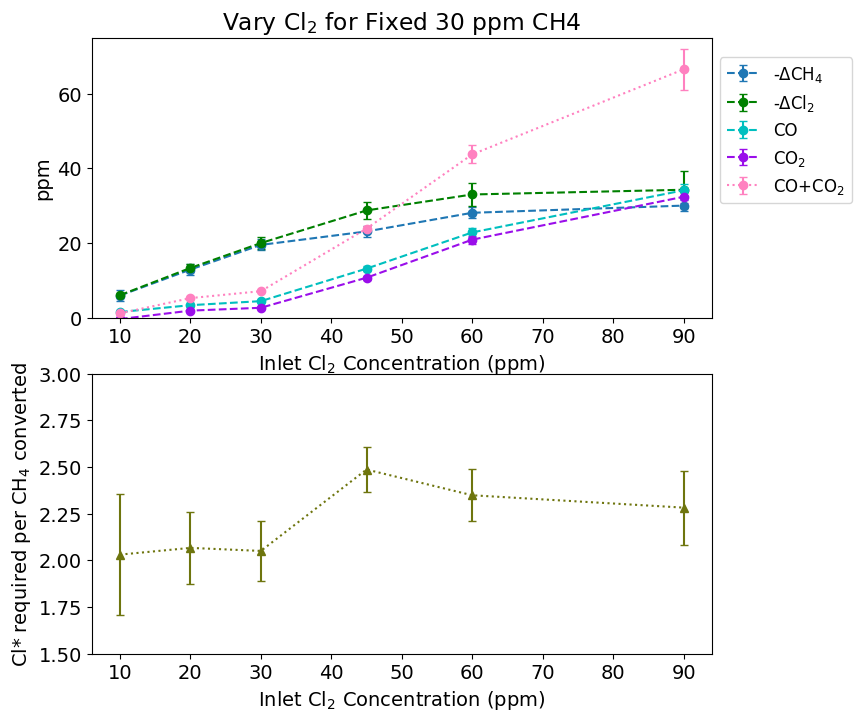

In [30]:
# Whittle it down to the experiments we want
exps = ["09-28-24 Vary Cl2 (20-90 ppm) at Fixed CH4","09-19-24 Vary Cl2 (5-30 ppm) at Fixed CH4"]
bypass_data = all_bypass_data[all_bypass_data["experiment_name"].isin(exps)]
conversion_data = all_conversion_data[all_conversion_data["experiment_name"].isin(exps)]
# Preferentially use the experiments with the 100-ppm Cl2 tank where we have the option to use either
conversion_data = conversion_data[(conversion_data['experiment_name']==exps[1]) | (conversion_data['Cl2 LabJack: Cl2 Node A (ppm) baseline']>35)]
conversion_data=conversion_data.sort_values(by='Cl2 LabJack: Cl2 Node A (ppm) baseline',ascending=True)

ftir_accuracy = 0.05

ch4_conversions = conversion_data['FTIR: CH4 (ppm) conversion']
#ch4_std = [var**0.5 for var in conversion_data['FTIR: CH4 (ppm) variance']]
ch4_std = [ftir_accuracy*x for x in conversion_data['FTIR: CH4 (ppm) baseline']]
start_times = conversion_data['start_time']

# Extract the means for each bypass period
means = (bypass_data.groupby('closest_start_time').mean(numeric_only=True).reset_index()) #Quick and dirty; we can use apply to do more involved operations, though.
co2 = [float(means[means.closest_start_time==t]['Picarro: CO2 (ppm)']) for t in start_times]
co = [float(means[means.closest_start_time==t]['FTIR: CO (ppm)']) for t in start_times]
stdevs = ((bypass_data.groupby('closest_start_time')).std(numeric_only=True).reset_index())
#co2_std = [float(stdevs[stdevs.closest_start_time==t]['Picarro: CO2 (ppm)']) for t in start_times]
#co_std = [float(stdevs[stdevs.closest_start_time==t]['FTIR: CO (ppm)']) for t in start_times]
co2_std = [ftir_accuracy*x for x in co2]
co_std = [ftir_accuracy*x for x in co]
co_co2_sum = [a+b for a,b in zip(co,co2)]
co_co2_std = [(a*a+b*b) for a,b in zip(co2_std,co_std)]

# Calculate the chlorine conversions -- either raw, or taking the conversion from the nodes but taking the baseline value from the MFC setpoint
if not use_nominal_cl2:
    cl2_conversions = conversion_data['Cl2 LabJack: Cl2 Node A (ppm) conversion']
    nom_cl2 = conversion_data['Cl2 LabJack: Cl2 Node A (ppm) baseline']
    #cl2_std = [v**0.5 for v in conversion_data['Cl2 LabJack: Cl2 Node A (ppm) variance']]
else:
    tanks = [(100 if '5-30' in name else 1000) for name in conversion_data['experiment_name']]
    nom_cl2 = [(tank/200.0)*float(means[means.closest_start_time==t]['Cl2 MFC: Setpoint Entry']) for t,tank in zip(start_times,tanks)]
    cl2_conversions = [conv*(nom/baseline) for nom,conv,baseline in zip(nom_cl2,conversion_data['Cl2 LabJack: Cl2 Node A (ppm) conversion'],conversion_data['Cl2 LabJack: Cl2 Node A (ppm) baseline'])]
    #cl2_std = [(var**0.5)*(nom/baseline) for nom,var,baseline in zip(nom_cl2,conversion_data['Cl2 LabJack: Cl2 Node A (ppm) variance'],conversion_data['Cl2 LabJack: Cl2 Node A (ppm) baseline'])]
#print(nom_cl2,'\n',list(conversion_data['Cl2 LabJack: Cl2 Node A (ppm) baseline']),'\n',list(conversion_data['Cl2 LabJack: Cl2 Node A (ppm) conversion']),'\n',cl2_conversions)
inlet_cl2 = nom_cl2
cl2_node_accuracy = 0.05
cl2_std = [cl2_node_accuracy*x for x in conversion_data['Cl2 LabJack: Cl2 Node A (ppm) baseline']]

# Setup subplots
plt.rcParams.update({'font.size': 14})
(fig,(ax1,ax2)) = plt.subplots(nrows=2,figsize=(8,8),sharex=True)

# Plot options
use_error_bars = True
show_products = True

# Make the first plot
if not use_error_bars:
    ax1.plot(inlet_cl2,ch4_conversions,label='-$\Delta$CH$_4$',marker='o',linestyle='--')
    ax1.plot(inlet_cl2,cl2_conversions,label='-$\Delta$Cl$_2$',color='g',marker='o',linestyle='--')
    if show_products:
        ax1.plot(inlet_cl2,co,label='CO',color='c',marker='o',linestyle='--')
        ax1.plot(inlet_cl2,co2,label='CO$_2$',color='xkcd:violet',marker='o',linestyle='--')
        ax1.plot(inlet_cl2,[a+b for a,b in zip(co,co2)],label='CO+CO$_2$',color='xkcd:pink',linestyle=':',marker='o')
else:
    ax1.errorbar(inlet_cl2,ch4_conversions,ch4_std,label='-$\Delta$CH$_4$',marker='o',linestyle='--',capsize=3)
    ax1.errorbar(inlet_cl2,cl2_conversions,cl2_std,label='-$\Delta$Cl$_2$',color='g',marker='o',linestyle='--',capsize=3)
    if show_products:
        ax1.errorbar(inlet_cl2,co,co_std,label='CO',color='c',marker='o',linestyle='--',capsize=3)
        ax1.errorbar(inlet_cl2,co2,co2_std,label='CO$_2$',color='xkcd:violet',marker='o',linestyle='--',capsize=3)
        ax1.errorbar(inlet_cl2,co_co2_sum,co_co2_std,label='CO+CO$_2$',color='xkcd:pink',linestyle=':',marker='o',capsize=3)
ax1.set_ylabel("ppm")
ax1.set_xlabel("Inlet Cl$_2$ Concentration (ppm)")
ax1.set_ylim(0,75)
ax1.legend(fontsize=12,loc='lower left',bbox_to_anchor=(1,0.38))
ax1.xaxis.set_tick_params(labelbottom=True)

# Make the second plot
ch4_per_cl_star = [2*b/a for a,b in zip(ch4_conversions,cl2_conversions)]
if not use_error_bars:
    ax2.plot(inlet_cl2,ch4_per_cl_star,label="CH$_4$ Converted per Cl*",color='xkcd:olive',linestyle=':',marker='^')
else:
    plot2_std = [max(abs(ch4/cl2-(ch4+std_ch4)/(cl2-std_cl2)),abs(ch4/cl2-(ch4-std_ch4)/(cl2+std_cl2))) for ch4,std_ch4,cl2,std_cl2 in zip(ch4_conversions,ch4_std,cl2_conversions,cl2_std)]
    ax2.errorbar(inlet_cl2,ch4_per_cl_star,plot2_std,label="CH$_4$ Converted per Cl*",color='xkcd:olive',linestyle=':',marker='^',capsize=3)
ax2.set_ylabel("Cl* required per CH$_4$ converted")
ax2.set_xlabel("Inlet Cl$_2$ Concentration (ppm)")
ax2.xaxis.set_tick_params(labelbottom=True)
ax2.set_ylim(1.5,3)

ax1.set_title("Vary Cl$_2$ for Fixed 30 ppm CH4")
plt.show()

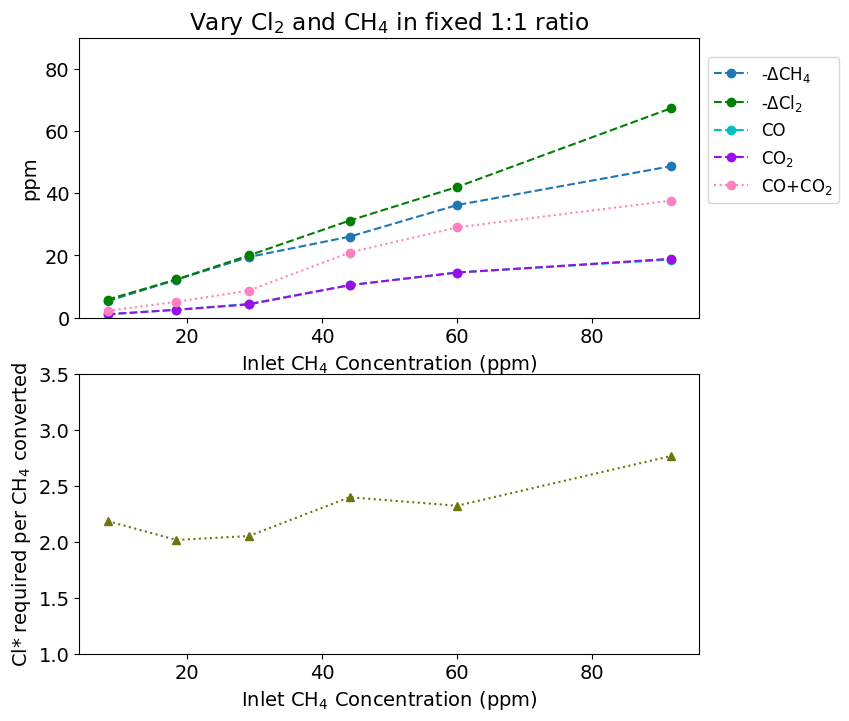

In [5]:
# Whittle it down to the experiments we want
exps = ["09-28-24 Vary Cl2 and CH4 1-to-1 (45-90 ppm)","09-19-24 Sweep 1-to-1 Cl2 and CH4 (10-20 ppm)","09-19-24 Vary Cl2 (5-30 ppm) at Fixed CH4"]
bypass_data = all_bypass_data[all_bypass_data["experiment_name"].isin(exps)]
conversion_data = all_conversion_data[all_conversion_data["experiment_name"].isin(exps)]
conversion_data = conversion_data[(conversion_data["experiment_name"]!="09-19-24 Vary Cl2 (5-30 ppm) at Fixed CH4") | (abs(conversion_data["Cl2 LabJack: Cl2 Node A (ppm) baseline"]-30)<2)]
conversion_data=conversion_data.sort_values(by='Cl2 LabJack: Cl2 Node A (ppm) baseline',ascending=True)

conversion_data=conversion_data.sort_values(by='FTIR: CH4 (ppm) baseline',ascending=True)
ch4_conversions = conversion_data['FTIR: CH4 (ppm) conversion']
inlet_ch4 = conversion_data['FTIR: CH4 (ppm) baseline']
start_times = conversion_data['start_time']

# Extract the means for each bypass period
means = (bypass_data.groupby('closest_start_time').mean(numeric_only=True).reset_index()) #Quick and dirty; we can use apply to do more involved operations, though.
co2 = [float(means[means.closest_start_time==t]['FTIR: CO2 (ppm)']) for t in start_times]
co = [float(means[means.closest_start_time==t]['FTIR: CO (ppm)']) for t in start_times]

# Calculate the chlorine conversions -- either raw, or taking the conversion from the nodes but taking the baseline value from the MFC setpoint
if not use_nominal_cl2:
    cl2_conversions = conversion_data['Cl2 LabJack: Cl2 Node A (ppm) conversion']
else:
    tanks = [(100 if ('10-20' in name) or ('5-30' in name) else 1000) for name in conversion_data['experiment_name']]
    nom_cl2 = [(tank/200.0)*float(means[means.closest_start_time==t]['Cl2 MFC: Setpoint Entry']) for t,tank in zip(start_times,tanks)]
    cl2_conversions = [conv*(nom/baseline) for nom,conv,baseline in zip(nom_cl2,conversion_data['Cl2 LabJack: Cl2 Node A (ppm) conversion'],conversion_data['Cl2 LabJack: Cl2 Node A (ppm) baseline'])]
#print(nom_cl2,'\n',list(conversion_data['Cl2 LabJack: Cl2 Node A (ppm) baseline']),'\n',list(conversion_data['Cl2 LabJack: Cl2 Node A (ppm) conversion']),'\n',cl2_conversions)

# Setup subplots
plt.rcParams.update({'font.size': 14})
(fig,(ax1,ax2)) = plt.subplots(nrows=2,figsize=(8,8),sharex=True)

# Make the first plot
ax1.plot(inlet_ch4,ch4_conversions,label='-$\Delta$CH$_4$',marker='o',linestyle='--')
ax1.plot(inlet_ch4,cl2_conversions,label='-$\Delta$Cl$_2$',color='g',marker='o',linestyle='--')
ax1.plot(inlet_ch4,co,label='CO',color='c',marker='o',linestyle='--')
ax1.plot(inlet_ch4,co2,label='CO$_2$',color='xkcd:violet',marker='o',linestyle='--')
ax1.plot(inlet_ch4,[a+b for a,b in zip(co,co2)],label='CO+CO$_2$',color='xkcd:pink',linestyle=':',marker='o')
ax1.set_ylabel("ppm")
ax1.set_xlabel("Inlet CH$_4$ Concentration (ppm)")
ax1.set_ylim(0,90)
ax1.legend(fontsize=12,loc='lower left',bbox_to_anchor=(1,0.38))
ax1.xaxis.set_tick_params(labelbottom=True)

# Make the second plot
ch4_per_cl_star = [2*b/a for a,b in zip(ch4_conversions,cl2_conversions)]
ax2.plot(inlet_ch4,ch4_per_cl_star,label="CH$_4$ Converted per Cl*",color='xkcd:olive',linestyle=':',marker='^')
ax2.set_ylabel("Cl* required per CH$_4$ converted")
ax2.set_xlabel("Inlet CH$_4$ Concentration (ppm)")
ax2.xaxis.set_tick_params(labelbottom=True)
ax2.set_ylim(1,3.5)

ax1.set_title("Vary Cl$_2$ and CH$_4$ in fixed 1:1 ratio")
plt.show()

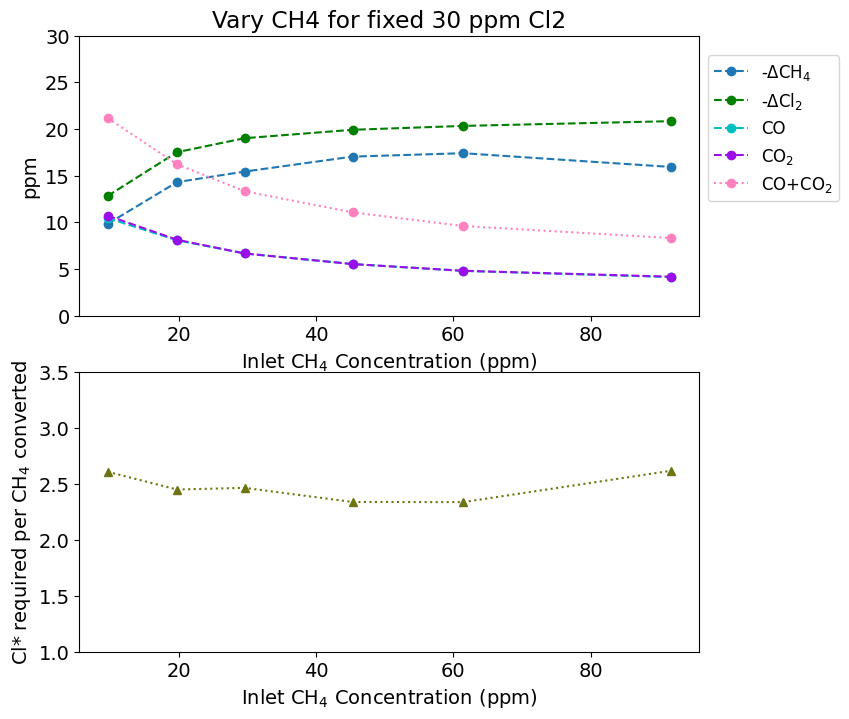

In [6]:
# Very methane for fixed Cl2
bypass_data = all_bypass_data[all_bypass_data["experiment_name"]=="09-30-24 Sweep CH4 (10-90 ppm)"]
conversion_data = all_conversion_data[all_conversion_data["experiment_name"]=="09-30-24 Sweep CH4 (10-90 ppm)"]
#bypass_data = all_bypass_data[all_bypass_data["experiment_name"].str.contains("09-19-24 Sweep 1-to-1 Cl2 and CH4")]
#conversion_data = all_conversion_data[all_conversion_data["experiment_name"].str.contains("09-19-24 Sweep 1-to-1 Cl2 and CH4")]
conversion_data=conversion_data.sort_values(by='Cl2 LabJack: Cl2 Node A (ppm) baseline',ascending=True)

conversion_data=conversion_data.sort_values(by='FTIR: CH4 (ppm) baseline',ascending=True)
ch4_conversions = conversion_data['FTIR: CH4 (ppm) conversion']
inlet_ch4 = conversion_data['FTIR: CH4 (ppm) baseline']
start_times = conversion_data['start_time']

# Extract the means for each bypass period
means = (bypass_data.groupby('closest_start_time').mean(numeric_only=True).reset_index()) #Quick and dirty; we can use apply to do more involved operations, though.
co2 = [float(means[means.closest_start_time==t]['FTIR: CO2 (ppm)']) for t in start_times]
co = [float(means[means.closest_start_time==t]['FTIR: CO (ppm)']) for t in start_times]

# Calculate the chlorine conversions -- either raw, or taking the conversion from the nodes but taking the baseline value from the MFC setpoint
if not use_nominal_cl2:
    cl2_conversions = conversion_data['Cl2 LabJack: Cl2 Node A (ppm) conversion']
else:
    nom_cl2 = [(1000.0/200.0)*float(means[means.closest_start_time==t]['Cl2 MFC: Setpoint Entry']) for t in start_times]
    cl2_conversions = [conv*(nom/baseline) for nom,conv,baseline in zip(nom_cl2,conversion_data['Cl2 LabJack: Cl2 Node A (ppm) conversion'],conversion_data['Cl2 LabJack: Cl2 Node A (ppm) baseline'])]
#print(nom_cl2,'\n',list(conversion_data['Cl2 LabJack: Cl2 Node A (ppm) baseline']),'\n',list(conversion_data['Cl2 LabJack: Cl2 Node A (ppm) conversion']),'\n',cl2_conversions)

# Setup subplots
plt.rcParams.update({'font.size': 14})
(fig,(ax1,ax2)) = plt.subplots(nrows=2,figsize=(8,8),sharex=True)

# Make the first plot
ax1.plot(inlet_ch4,ch4_conversions,label='-$\Delta$CH$_4$',marker='o',linestyle='--')
ax1.plot(inlet_ch4,cl2_conversions,label='-$\Delta$Cl$_2$',color='g',marker='o',linestyle='--')
ax1.plot(inlet_ch4,co,label='CO',color='c',marker='o',linestyle='--')
ax1.plot(inlet_ch4,co2,label='CO$_2$',color='xkcd:violet',marker='o',linestyle='--')
ax1.plot(inlet_ch4,[a+b for a,b in zip(co,co2)],label='CO+CO$_2$',color='xkcd:pink',linestyle=':',marker='o')
ax1.set_ylabel("ppm")
ax1.set_xlabel("Inlet CH$_4$ Concentration (ppm)")
ax1.set_ylim(0,30)
ax1.legend(fontsize=12,loc='lower left',bbox_to_anchor=(1,0.38))
ax1.xaxis.set_tick_params(labelbottom=True)

# Make the second plot
ch4_per_cl_star = [2*b/a for a,b in zip(ch4_conversions,cl2_conversions)]
ax2.plot(inlet_ch4,ch4_per_cl_star,label="CH$_4$ Converted per Cl*",color='xkcd:olive',linestyle=':',marker='^')
ax2.set_ylabel("Cl* required per CH$_4$ converted")
ax2.set_xlabel("Inlet CH$_4$ Concentration (ppm)")
ax2.xaxis.set_tick_params(labelbottom=True)
ax2.set_ylim(1,3.5)

ax1.set_title("Vary CH4 for fixed 30 ppm Cl2")
plt.show()

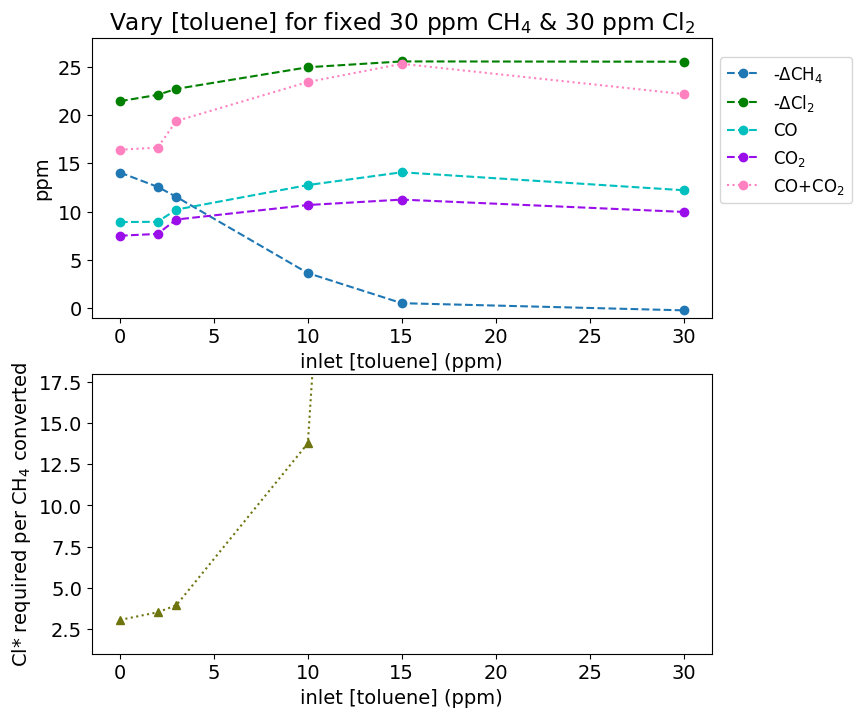

In [7]:
# Whittle it down to the experiments we want
bypass_data = all_bypass_data[all_bypass_data["experiment_name"]=='10-01-24 Sweep Toluene']
conversion_data = all_conversion_data[all_conversion_data["experiment_name"]=='10-01-24 Sweep Toluene']

ch4_conversions = conversion_data['FTIR: CH4 (ppm) conversion']
start_times = conversion_data['start_time']

# Extract the means for each bypass period
means = (bypass_data.groupby('closest_start_time').mean(numeric_only=True).reset_index()) #Quick and dirty; we can use apply to do more involved operations, though.
#x_vals = [float(means[means.closest_start_time==t]['LF N2 MFC: Actual Flow']) for t in start_times] #Lookup the correct entry in the groupby
#x_vals = [v*(100.0/200.0) for v in x_vals] # Scale appropriately to adjust for added chlorine flow
x_vals = [0,2,3,10,15,30]
co2 = [float(means[means.closest_start_time==t]['Picarro: CO2 (ppm)']) for t in start_times]
co = [float(means[means.closest_start_time==t]['FTIR: CO (ppm)']) for t in start_times]

# Calculate the chlorine conversions -- either raw, or taking the conversion from the nodes but taking the baseline value from the MFC setpoint
if not use_nominal_cl2:
    cl2_conversions = conversion_data['Cl2 LabJack: Cl2 Node A (ppm) conversion']
else:
    nom_cl2 = [(1000.0/200.0)*float(means[means.closest_start_time==t]['Cl2 MFC: Setpoint Entry']) for t in start_times]
    cl2_conversions = [conv*(nom/baseline) for nom,conv,baseline in zip(nom_cl2,conversion_data['Cl2 LabJack: Cl2 Node A (ppm) conversion'],conversion_data['Cl2 LabJack: Cl2 Node A (ppm) baseline'])]
#print(nom_cl2,'\n',list(conversion_data['Cl2 LabJack: Cl2 Node A (ppm) baseline']),'\n',list(conversion_data['Cl2 LabJack: Cl2 Node A (ppm) conversion']),'\n',cl2_conversions)

# Setup subplots
plt.rcParams.update({'font.size': 14})
(fig,(ax1,ax2)) = plt.subplots(nrows=2,figsize=(8,8),sharex=True)

# Make the first plot
ax1.plot(x_vals,ch4_conversions,label='-$\Delta$CH$_4$',marker='o',linestyle='--')
ax1.plot(x_vals,cl2_conversions,label='-$\Delta$Cl$_2$',color='g',marker='o',linestyle='--')
ax1.plot(x_vals,co,label='CO',color='c',marker='o',linestyle='--')
ax1.plot(x_vals,co2,label='CO$_2$',color='xkcd:violet',marker='o',linestyle='--')
ax1.plot(x_vals,[a+b for a,b in zip(co,co2)],label='CO+CO$_2$',color='xkcd:pink',linestyle=':',marker='o')
ax1.set_ylabel("ppm")
ax1.set_xlabel("inlet [toluene] (ppm)")
ax1.set_ylim(-1,28)
ax1.legend(fontsize=12,loc='lower left',bbox_to_anchor=(1,0.38))
ax1.xaxis.set_tick_params(labelbottom=True)

# Make the second plot
ch4_per_cl_star = [2*b/a for a,b in zip(ch4_conversions,cl2_conversions)]
ax2.plot(x_vals[:5],ch4_per_cl_star[:5],label="CH$_4$ Converted per Cl*",color='xkcd:olive',linestyle=':',marker='^')
ax2.set_ylabel("Cl* required per CH$_4$ converted")
ax2.set_xlabel("inlet [toluene] (ppm)")
ax2.xaxis.set_tick_params(labelbottom=True)
ax2.set_ylim(1,18)


ax1.set_title("Vary [toluene] for fixed 30 ppm CH$_4$ & 30 ppm Cl$_2$")
plt.show()

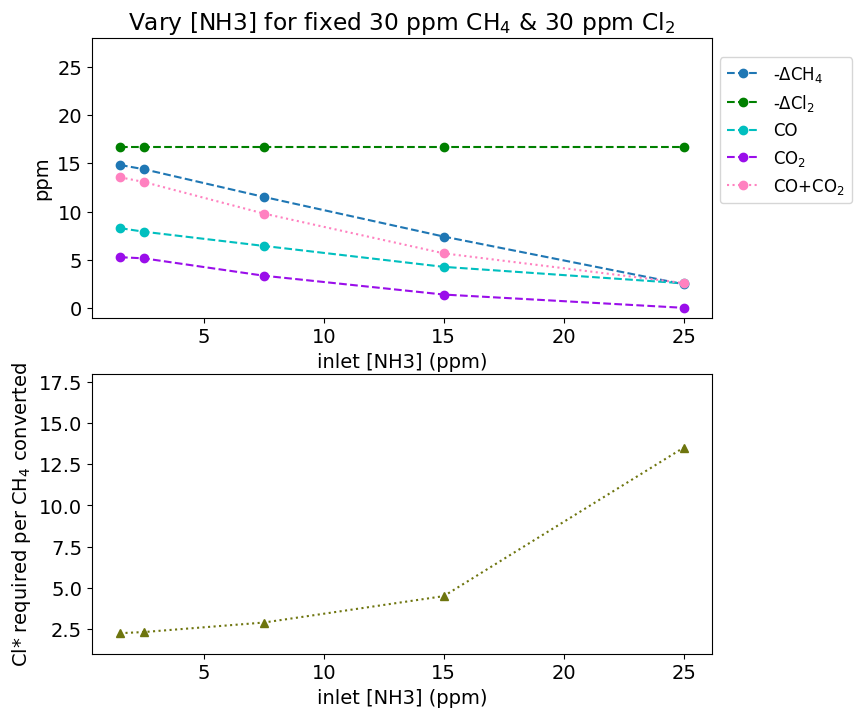

In [8]:
# Whittle it down to the experiments we want
bypass_data = all_bypass_data[all_bypass_data["experiment_name"]=='10-03-24 Sweep NH3']
conversion_data = all_conversion_data[all_conversion_data["experiment_name"]=='10-03-24 Sweep NH3']

ch4_conversions = conversion_data['FTIR: CH4 (ppm) conversion']
cl2_conversions = conversion_data['Cl2 LabJack: Cl2 Node A (ppm) conversion']
cl2_conversions = [list(cl2_conversions)[0] for c in cl2_conversions]
start_times = conversion_data['start_time']

# Extract the means for each bypass period
means = (bypass_data.groupby('closest_start_time').mean(numeric_only=True).reset_index()) #Quick and dirty; we can use apply to do more involved operations, though.
x_vals = [float(means[means.closest_start_time==t]['LF N2 MFC: Actual Flow']) for t in start_times] #Lookup the correct entry in the groupby
x_vals = [v*(100.0/200.0) for v in x_vals] # Scale appropriately to adjust for added chlorine flow
co2 = [float(means[means.closest_start_time==t]['Picarro: CO2 (ppm)']) for t in start_times]
co = [float(means[means.closest_start_time==t]['FTIR: CO (ppm)']) for t in start_times]

# Setup subplots
plt.rcParams.update({'font.size': 14})
(fig,(ax1,ax2)) = plt.subplots(nrows=2,figsize=(8,8),sharex=True)

# Make the first plot
ax1.plot(x_vals,ch4_conversions,label='-$\Delta$CH$_4$',marker='o',linestyle='--')
ax1.plot(x_vals,cl2_conversions,label='-$\Delta$Cl$_2$',color='g',marker='o',linestyle='--')
ax1.plot(x_vals,co,label='CO',color='c',marker='o',linestyle='--')
ax1.plot(x_vals,co2,label='CO$_2$',color='xkcd:violet',marker='o',linestyle='--')
ax1.plot(x_vals,[a+b for a,b in zip(co,co2)],label='CO+CO$_2$',color='xkcd:pink',linestyle=':',marker='o')
ax1.set_ylabel("ppm")
ax1.set_xlabel("inlet [NH3] (ppm)")
ax1.set_ylim(-1,28)
ax1.legend(fontsize=12,loc='lower left',bbox_to_anchor=(1,0.38))
ax1.xaxis.set_tick_params(labelbottom=True)

# Make the second plot
ch4_per_cl_star = [2*b/a for a,b in zip(ch4_conversions,cl2_conversions)]
ax2.plot(x_vals,ch4_per_cl_star,label="CH$_4$ Converted per Cl*",color='xkcd:olive',linestyle=':',marker='^')
ax2.set_ylabel("Cl* required per CH$_4$ converted")
ax2.set_xlabel("inlet [NH3] (ppm)")
ax2.xaxis.set_tick_params(labelbottom=True)
ax2.set_ylim(1,18)


ax1.set_title("Vary [NH3] for fixed 30 ppm CH$_4$ & 30 ppm Cl$_2$")
plt.show()

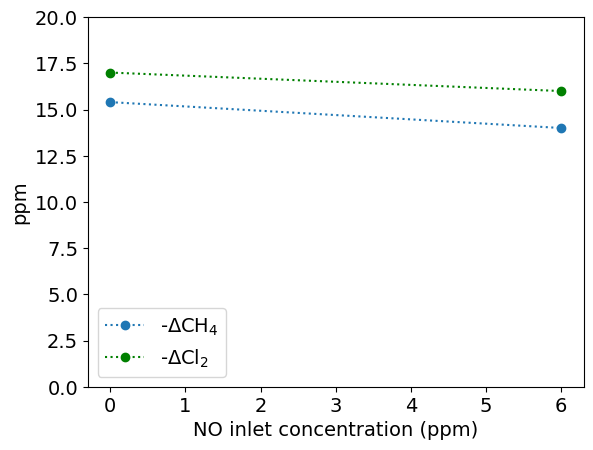

In [9]:
# Whittle it down to the experiments we want
conversion_data = all_conversion_data[all_conversion_data["experiment_name"]=='10-02-24 Add NO']
import numpy as np

ch4_conversions = conversion_data['FTIR: CH4 (ppm) conversion']
cl2_conversions = conversion_data['Cl2 LabJack: Cl2 Node A (ppm) conversion']

fix,ax = plt.subplots()
no = [0,6]
delta_ch4 = [15.4,14.0]
delta_cl2 = [17,16]
ax.plot(no,delta_ch4,'o:',label='-$\Delta$CH$_4$')
ax.plot(no,delta_cl2,'o:g',label='-$\Delta$Cl$_2$')
ax.set_ylim(0,20)
ax.set_ylabel('ppm')
ax.set_xlabel('NO inlet concentration (ppm)')
ax.legend()
plt.show()





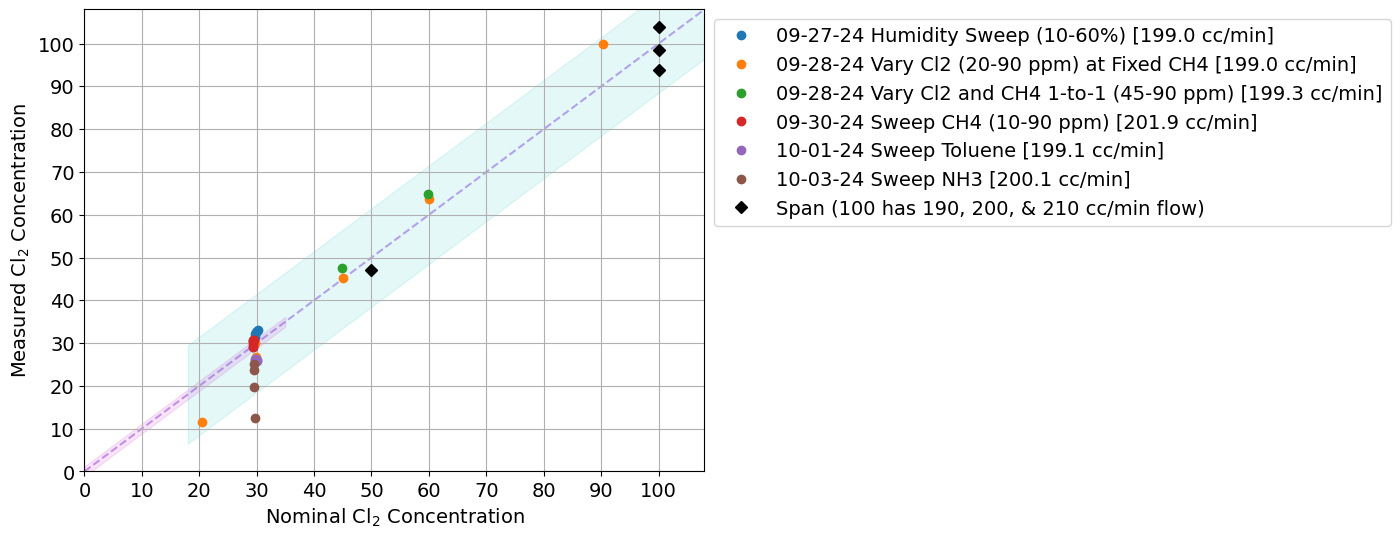

In [10]:
# Cl2 accuracy checker

# Make the plot
(fig,ax) = plt.subplots(figsize=(8,6))
import numpy as np

# Directly extract the data from the conversions file
all_conversion_data_2 = conversion_data_929[conversion_data_929['experiment_name']!="10-02-24 Add NO"].copy(deep=True)
all_bypass_data_2 = bypass_data_929[bypass_data_929['experiment_name']!="10-02-24 Add NO"].copy(deep=True)
cl2_from_sensor = all_conversion_data_2['Cl2 LabJack: Cl2 Node A (ppm) baseline']
start_times = all_conversion_data_2['start_time']
cl2_tank_concs = [1000 for x in start_times]# Make this a more complicated conditional if different experiments use different Cl2 tank concentrations

# Extract the data from the bypass file
all_bypass_data_2['Valve Position Numeric'] = [(1 if x=='No Bubbler' else 0) for x in all_bypass_data_2['Bubbler Bypass Valve: Actual Position']]
means = (all_bypass_data_2.groupby('closest_start_time').mean(numeric_only=True).reset_index()) #Quick and dirty; we can use apply to do more involved operations, though.
cl2_mfc_flows = [float(means[means.closest_start_time==t]['Cl2 MFC: Actual Flow']) for t in start_times] #Lookup the correct entry in the groupby
cl2_mfc_setpoints = [float(means[means.closest_start_time==t]['Cl2 MFC: Setpoint Entry']) for t in start_times] #Lookup the correct entry in the groupby
total_flows = [float(means[means.closest_start_time==t]['MFM: Actual Flow']) for t in start_times] #Lookup the correct entry in the groupby
cl2_calculated = [cl2_tank_conc*cl2_mfc_flow/total_flow for cl2_tank_conc,cl2_mfc_flow,total_flow in zip(cl2_tank_concs,cl2_mfc_flows,total_flows)]
cl2_nominal = [cl2_tank_conc*cl2_mfc_setpoint/200 for cl2_tank_conc,cl2_mfc_setpoint,total_flow in zip(cl2_tank_concs,cl2_mfc_setpoints,total_flows)]
bypass_avg = [float(means[means.closest_start_time==t]['Valve Position Numeric']) for t in start_times] #Lookup the correct entry in the groupby

# Clone conversion data
all_conversion_data_2["Nominal Cl2 (ppm)"] = cl2_nominal
all_conversion_data_2["Calculated Cl2 (ppm)"] = cl2_calculated
all_conversion_data_2["Valve Position Numeric"] = bypass_avg
all_conversion_data_2["Valve Position Numeric"] = bypass_avg
all_conversion_data_2["Average Flow"] = total_flows

# Do the plotting
#ax.plot(cl2_nominal,cl2_from_sensor,'go')
color = 0
for name, group in all_conversion_data_2.groupby(by="experiment_name"):
    subgroup = group[group['Valve Position Numeric']==1]
    if not subgroup.empty:
        flow = round(np.average(subgroup['Average Flow']),1)
        mod = " ["+str(flow)+" cc/min]"
        ax.plot(subgroup['Calculated Cl2 (ppm)'],subgroup['Cl2 LabJack: Cl2 Node A (ppm) baseline'],'o',label=name+mod,color='C'+str(color%8))
    color+=1
color = 0
for name, group in all_conversion_data_2.groupby(by="experiment_name"):
    subgroup = group[group['Valve Position Numeric']==0]
    if not subgroup.empty:
        ax.plot(subgroup['Calculated Cl2 (ppm)'],subgroup['Cl2 LabJack: Cl2 Node A (ppm) baseline'],'^',color='C'+str(color%8))
    color+=1
m = max(cl2_from_sensor)

# Draw the spec'd region for the high range
error = 1.5+10.0
x = np.array([18,110])
y = np.array([18,110])
ax.fill_between(x, y-error, y+error,color='c',alpha=0.1)

# Draw the spec'd region for the low range
error = 0.15+1.00
x = np.array([0,35])
y = np.array([0,35])
ax.fill_between(x, y-error, y+error,color='m',alpha=0.1)

# Attempt to draw a line of best fit thru the 1000 tank results

# Attempt to draw one thru the 100 results

# Cosmetics
ax.grid(which='both')
ax.set_xticks([0,10,20,30,40,50,60,70,80,90,100])
ax.set_yticks([0,10,20,30,40,50,60,70,80,90,100])

# Most recent data point
span = 1.23
cal = lambda x: (x-45.5)*30/(83-45.5)
raw_vals = [104.5,162.9,168.6,175.5]
cal_vals = [cal(x) for x in raw_vals]
#print([round(x,1) for x in cal_vals])
ax.plot([50,100,100,100],cal_vals,'kD',label='Span (100 has 190, 200, & 210 cc/min flow)')

ax.plot([0,110],[0,110],'--',color='xkcd:lavender',zorder=-10)
ax.legend(loc='upper left',bbox_to_anchor=(1,1))
ax.set_xlabel("Nominal Cl$_2$ Concentration")
ax.set_ylabel("Measured Cl$_2$ Concentration")
ax.set_xlim(0,108)
ax.set_ylim(0,108)
plt.show()